# An active inference model of Lacanian psychoanalysis

### Python implementation

First import necessary modules

In [2]:
import os
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools

from pymdp import utils
from pymdp.maths import softmax
from pymdp.maths import spm_log_single as log_stable
from pymdp.control import construct_policies

In this instructive simulation, we set a simple condition that three basic units share, as follows:

In [3]:
states = [0,1,2,3,4,5,6,7,8]
observation = [0,1,2,3,4,5,6,7,8]
actions = ["UP", "DOWN", "STAY"]
n_states = 9
n_observation = 9
n_actions = 3

In [4]:
#Plot beliefs 
def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='gray', zorder=3)
    plt.xticks(range(belief_dist.shape[0]),list(states))
    plt.title(title_str)
    plt.show()

# Create transition matrix B, and the matrix A would be explicitly created later
def create_B_matrix():
  B = np.zeros((len(states), len(states), len(actions)))

  for action_id, action_label in enumerate(actions):
    for curr_state, imagstate in enumerate(states):
      x = imagstate

      if action_label == "UP":
        next_x = np.where(x < 8, x + 1, x)
      elif action_label == "DOWN":
        next_x = np.where(x > 0, x - 1, x)
      elif action_label == "STAY":
        next_x = x

      new_state = next_x
      next_state = states.index(next_x)
      B[next_state, curr_state, action_id] = 1.0

  return B

# Get approxiamate posterior
def infer_states(observation_index, A, prior):

  """ Implement inference here -- NOTE: prior is already passed in, so you don't need to do anything with the B matrix. """
  """ This function has already been given P(s_t). The conditional expectation that creates "today's prior", using "yesterday's posterior", will happen *before calling* this function"""
  
  log_likelihood = log_stable(A[observation_index,:])

  log_prior = log_stable(prior)

  qs = softmax(log_likelihood + log_prior)
   
  return qs

#Calculate $P(s|s,pi)$
def get_expected_states(B, qs_current, action):
  """ Compute the expected states one step into the future, given a particular action """
  qs_u = B[:,:,action].dot(qs_current)

  return qs_u

#$P(o|qs_u)$
def get_expected_observations(A, qs_u):
  """ Compute the expected observations one step into the future, given a particular action """

  qo_u = A.dot(qs_u)

  return qo_u

#
def entropy(A):
  """ Compute the entropy of a set of conditional distributions, i.e. one entropy value per column """

  H_A = - (A * log_stable(A)).sum(axis=0)

  return H_A

def kl_divergence(a, b):
  """ Compute the Kullback-Leibler divergence between two 1-D categorical distributions"""
  
  return (log_stable(a) - log_stable(b)).dot(a)

# Calculate expected free energy G
def calculate_G(A, B, C, qs_current, actions):

  G = np.zeros(len(actions)) # vector of expected free energies, one per action

  H_A = entropy(A) # entropy of the observation model, P(o|s)

  for action_i in range(len(actions)):
    
    qs_u = get_expected_states(B, qs_current, action_i) # expected states, under the action we're currently looping over
    qo_u = get_expected_observations(A, qs_u)           # expected observations, under the action we're currently looping over

    pred_uncertainty = H_A.dot(qs_u) # predicted uncertainty, i.e. expected entropy of the A matrix
    pred_div = kl_divergence(qo_u, C) # predicted divergence

    G[action_i] = pred_uncertainty + pred_div # sum them together to get expected free energy
  
  return G

# Calculate alternative policies
def construct_policies(num_states, num_controls = None, policy_len=1, control_fac_idx=None):
    num_factors = len(num_states)
    if control_fac_idx is None:
        if num_controls is not None:
            control_fac_idx = [f for f, n_c in enumerate(num_controls) if n_c > 1]
        else:
            control_fac_idx = list(range(num_factors))

    if num_controls is None:
        num_controls = [num_states[c_idx] if c_idx in control_fac_idx else 1 for c_idx in range(num_factors)]
        
    x = num_controls * policy_len
    policies = list(itertools.product(*[list(range(i)) for i in x]))
    for pol_i in range(len(policies)):
        policies[pol_i] = np.array(policies[pol_i]).reshape(policy_len, num_factors)

    return policies

# For every alternative policy, calculate its expected free energy
def calculate_G_policies(A, B, C, qs_current, policies):

  G = np.zeros(len(policies)) # initialize the vector of expected free energies, one per policy
  H_A = entropy(A)            # can calculate the entropy of the A matrix beforehand, since it'll be the same for all policies

  for policy_id, policy in enumerate(policies): # loop over policies - policy_id will be the linear index of the policy (0, 1, 2, ...) and `policy` will be a column vector where `policy[t,0]` indexes the action entailed by that policy at time `t`

    t_horizon = policy.shape[0] # temporal depth of the policy

    G_pi = 0.0 # initialize expected free energy for this policy

    for t in range(t_horizon): # loop over temporal depth of the policy

      action = policy[t,0] # action entailed by this particular policy, at time `t`

      # get the past predictive posterior - which is either your current posterior at the current time (not the policy time) or the predictive posterior entailed by this policy, one timstep ago (in policy time)
      if t == 0:
        qs_prev = qs_current 
      else:
        qs_prev = qs_pi_t
        
      qs_pi_t = get_expected_states(B, qs_prev, action) # expected states, under the action entailed by the policy at this particular time
      qo_pi_t = get_expected_observations(A, qs_pi_t)   # expected observations, under the action entailed by the policy at this particular time

      kld = kl_divergence(qo_pi_t, C) # Kullback-Leibler divergence between expected observations and the prior preferences C

      G_pi_t = H_A.dot(qs_pi_t) + kld # predicted uncertainty + predicted divergence, for this policy & timepoint

      G_pi += G_pi_t # accumulate the expected free energy for each timepoint into the overall EFE for the policy

    G[policy_id] += G_pi
  
  return G

def compute_prob_actions(actions, policies, Q_pi):
  P_u = np.zeros(len(actions)) # initialize the vector of probabilities of each action

  for policy_id, policy in enumerate(policies):
    P_u[int(policy[0,0])] += Q_pi[policy_id] # get the marginal probability for the given action, entailed by this policy at the first timestep
  
  P_u = utils.norm_dist(P_u) # normalize the action probabilities
  
  return P_u

# Simulating the T-steps active inference process with "policy_len"-steps planning
def active_inference_with_planning(A, B, C, D, obs_idx, n_actions, env, policy_len, T):

  """ Initialize prior, first observation, and policies """
  
  prior = D # initial prior should be the D vector
  if obs_idx == None: #if obs is not provided, reset the environment
    obs = env.reset()
  else:
    obs = observation[obs_idx]

  policies = construct_policies([n_states], [n_actions], policy_len = policy_len)
  

  for t in range(T):

    print(f'Time {t}: Agent observes itself in location: {obs}')

    # convert the observation into the agent's observational state space (in terms of 0 through 8)
    obs_idx = observation.index(obs)

    # perform inference over hidden states
    qs_current = infer_states(obs_idx, A, prior)
    

    # calculate expected free energy of actions
    G = calculate_G_policies(A, B, C, qs_current, policies)

    # to get action posterior, we marginalize P(u|pi) with the probabilities of each policy Q(pi), given by \sigma(-G)
    Q_pi = softmax(-G)

    # compute the probability of each action
    P_u = compute_prob_actions(actions, policies, Q_pi)

    # sample action from probability distribution over actions
    chosen_action = utils.sample(P_u)

    # compute prior for next timestep of inference
    prior = B[:,:,chosen_action].dot(qs_current) 

    # step the generative process and get new observation
    action_label = actions[chosen_action]
    obs = env.step(action_label)
  
  #get the final observation index
  obs_idx = observation.index(obs)
  #infer the final state
  qs_current = infer_states(obs_idx, A, prior)
  #plot the beliefs of final state
  
  
  #calculate actual free energy
  dkl = kl_divergence(qs_current,A[obs_idx,:])
  evidence = log_stable(prior)
  F = dkl - evidence
 
  return obs_idx,qs_current,F

#After policy taken, the divergence of current states and original preferences is calculated as residual free energy
def residual(C,qs):
    R = kl_divergence(C,qs)
    return R

#priors update based on residual free energy
def D_update(D,F,R,w):
    if w is None:
      w = 1
    p = np.argmin(F) #sample the item with minimal actual free energy
    F[p] = F[p]+w*R #add the residual free energy to this item, forming a new variational free energy
    D = softmax(-F) #update priors vector over current state according to the new F
    return D

#Change the preference vector C according to observations dynamically
def change_C (obs_idx):
    C = utils.onehot(observation.index(obs_idx), n_observation)
    return C 

In [5]:
class RealEnv():
    
    def __init__(self,starting_state = (5)):

        self.init_state = starting_state
        self.current_state = self.init_state
        print(f'Starting state is {starting_state}')
    
    def step(self,action_label):

        x = self.current_state

        if action_label == "UP":
          next_x = np.where(x < 8, x + 1, x)
        elif action_label == "DOWN":
          next_x = np.where(x > 0, x - 1, x)
        elif action_label == "STAY":
          next_x = x
        
        self.current_state = (next_x)

        obs = self.current_state

        return obs

    def reset(self):
        self.current_state = self.init_state
        print(f'Re-initialized location to {self.init_state}')
        obs = self.current_state
        print(f'..and sampled observation {obs}')

        return obs
    
env_r = RealEnv()

class SymEnv():
    
    def __init__(self,starting_state = (0)):

        self.init_state = starting_state
        self.current_state = self.init_state
        print(f'Starting state is {starting_state}')
    
    def step(self,action_label):

        x = self.current_state

        if action_label == "UP":
          next_x = np.where(x < 8, x + 1, x)
        elif action_label == "DOWN":
          next_x = np.where(x > 0, x - 1, x)
        elif action_label == "STAY":
          next_x = x
        
        self.current_state = (next_x)

        obs = self.current_state

        return obs

    def reset(self):
        self.current_state = self.init_state
        print(f'Re-initialized location to {self.init_state}')
        obs = self.current_state
        print(f'..and sampled observation {obs}')

        return obs

env_s = SymEnv()

class ImagEnv():
    
    def __init__(self,starting_state = (5)):

        self.init_state = starting_state
        self.current_state = self.init_state
        print(f'Starting state is {starting_state}')
    
    def step(self,action_label):

        x = self.current_state

        if action_label == "UP":
          next_x = np.where(x < 8, x + 1, x)
        elif action_label == "DOWN":
          next_x = np.where(x > 0, x - 1, x)
        elif action_label == "STAY":
          next_x = x
        
        self.current_state = (next_x)

        obs = self.current_state

        return obs

    def reset(self):
        self.current_state = self.init_state
        print(f'Re-initialized location to {self.init_state}')
        obs = self.current_state
        print(f'..and sampled observation {obs}')

        return obs
    
env_i = ImagEnv()


Starting state is 5
Starting state is 0
Starting state is 5


In [6]:
class Agent:
    def __init__(self):
        # Create instances of the three environments
        self.env_r = RealEnv()
        self.env_s = SymEnv()
        self.env_i = ImagEnv()
        self.trajectory = [] #

    # Implement the active inference process
    def run_active_inference(self, epochs):
        # Fill out the components of the generative model for each environment inside this method
        """ Fill out the components of the generative model """
        A_R = A.copy()
        B_R = create_B_matrix()
        C_R = utils.onehot(observation.index(5), n_observation)  # preference
        D_R = utils.onehot(states.index(5), n_states)  # priors over initial state
        actions = ["UP", "DOWN", "STAY"]

        """ Fill out the components of the generative model """
        A_S = A.copy()
        B_S = create_B_matrix()
        #Set the preference of the Symbolic as 4, while its starting state is 0. So it could be thought as a perturbation.
        C_S = utils.onehot(observation.index(4), n_observation)
        D_S = utils.onehot(states.index(0), n_states)
        actions = ["UP", "DOWN", "STAY"]

        """ Fill out the components of the generative model """
        A_I = A.copy()
        B_I = create_B_matrix()
        #We set a sligt perturbation of the Imaginary here
        C_I = utils.onehot(observation.index(6), n_observation)
        D_I = utils.onehot(states.index(6), n_states)
        actions = ["UP", "DOWN", "STAY"]

        for j in range(epochs):
            # Run active inference in each environment using the appropriate generative model
            print("epoch:", j)
            if j == 0:
                obs_idx_r, qs_curr_r, F_r = active_inference_with_planning(A_R, B_R, C_R, D_R, 5, n_actions, self.env_r, policy_len=2, T=2)
                obs_idx_s, qs_curr_s, F_s = active_inference_with_planning(A_S, B_S, C_S, D_S, 0, n_actions, self.env_s, policy_len=4, T=1)
                obs_idx_i, qs_curr_i, F_i = active_inference_with_planning(A_I, B_I, C_I, D_I, 6, n_actions, self.env_i, policy_len=2, T=1)
            else:
                obs_idx_r,qs_curr_r,F_r = active_inference_with_planning(A_R, B_R, C_R, D_R, obs_idx_r, n_actions, self.env_r, policy_len = 2, T = 2)
                obs_idx_s,qs_curr_s,F_s = active_inference_with_planning(A_S, B_S, C_S, D_S, obs_idx_s, n_actions, self.env_s, policy_len = 4, T = 1)
                obs_idx_i,qs_curr_i,F_i = active_inference_with_planning(A_I, B_I, C_I, D_I, obs_idx_i, n_actions, self.env_i, policy_len = 2, T = 1)
            # Update priors based on residual free energy
            # Residual free energy passage
            R = residual(C_R, qs_curr_r) + residual(C_S, qs_curr_s) + residual(C_I, qs_curr_i)
            D_R = D_update(D_R, F_r, R, 2)
            D_S = D_update(D_S, F_s, R, 0.5)
            D_I = D_update(D_I, F_i, R, 1)
            
            self.trajectory.append([obs_idx_r, obs_idx_s, obs_idx_i])           
    
    # Visulize the dynamics in a 3D space.
    def plot_trajectory(self):
        # Plot the 3D orbit
        trajectory = np.array(self.trajectory)
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        x = trajectory[:, 0]
        y = trajectory[:, 1]
        z = trajectory[:, 2]
        # Set the axis limits
        ax.set_xlim3d(0, 8)
        ax.set_ylim3d(0, 8)
        ax.set_zlim3d(0, 8)
        # Plot the trajectory as a line
        ax.plot(x, y, z, c='gray', linewidth=2, linestyle='-')

        # Plot the individual points
        ax.scatter(x, y, z, c='gray', s=25, marker='o',)

        # Customize axis labels and title
        ax.set_xlabel('The Real', fontsize=12)
        ax.set_ylabel('The Symbolic', fontsize=12)
        ax.set_zlabel('The Imaginary', fontsize=12)
        ax.set_title('3D Orbit of Observations', fontsize=16)

        # Customize the grid and background
        ax.grid(False)
        ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

        # Customize the legend
        ax.legend(loc='upper right', fontsize=10)

        plt.show()

In [7]:
#Create likelihood matrix A
A = np.array([
    [0.85, 0.05, 0.04, 0.03, 0.02, 0.01, 0.00, 0.00, 0.00],
    [0.05, 0.80, 0.05, 0.04, 0.03, 0.02, 0.01, 0.00, 0.00],
    [0.04, 0.05, 0.76, 0.05, 0.04, 0.03, 0.02, 0.01, 0.00],
    [0.03, 0.04, 0.05, 0.73, 0.05, 0.04, 0.03, 0.02, 0.01],
    [0.02, 0.03, 0.04, 0.05, 0.72, 0.05, 0.04, 0.03, 0.02],
    [0.01, 0.02, 0.03, 0.04, 0.05, 0.73, 0.05, 0.04, 0.03],
    [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.76, 0.05, 0.04],
    [0.00, 0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.80, 0.05],
    [0.00, 0.00, 0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.85]
])

Starting state is 5
Starting state is 0
Starting state is 5
epoch: 0
Time 0: Agent observes itself in location: 5
Time 1: Agent observes itself in location: 5
Time 0: Agent observes itself in location: 0
Time 0: Agent observes itself in location: 6
epoch: 1
Time 0: Agent observes itself in location: 5
Time 1: Agent observes itself in location: 4
Time 0: Agent observes itself in location: 1
Time 0: Agent observes itself in location: 5
epoch: 2
Time 0: Agent observes itself in location: 4
Time 1: Agent observes itself in location: 4
Time 0: Agent observes itself in location: 2
Time 0: Agent observes itself in location: 6
epoch: 3
Time 0: Agent observes itself in location: 4
Time 1: Agent observes itself in location: 3
Time 0: Agent observes itself in location: 3
Time 0: Agent observes itself in location: 7
epoch: 4
Time 0: Agent observes itself in location: 3
Time 1: Agent observes itself in location: 3
Time 0: Agent observes itself in location: 4
Time 0: Agent observes itself in locatio

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


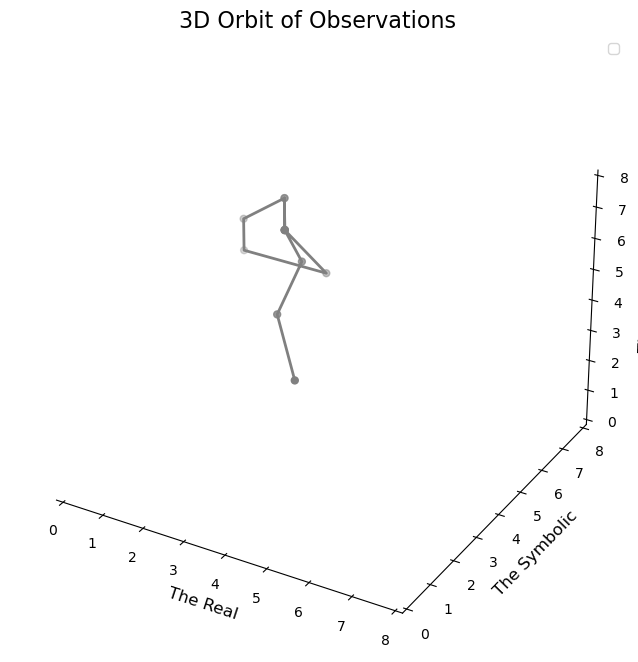

In [8]:
# Simulate the active inference process when the Symbolic is pertubated
agent = Agent()
agent.run_active_inference(15)#15-steps
agent.plot_trajectory()

#### Desire running as partial synchronization

In [9]:
class Sync:
    def __init__(self):
        self.env_r = RealEnv()
        self.env_s = SymEnv()
        self.env_i = ImagEnv()
        self.trajectory_a = []
        self.trajectory_b = []   
    
    def run_active_inference(self,epochs):
        """define matrices"""
        obs_idx_s_b = 4
        obs_idx_s_a = 2
        """ Fill out the components of the generative model """
        A_R_a = A.copy()
        B_R_a = create_B_matrix()
        C_R_a = utils.onehot(observation.index(8), n_observation)  # preference
        D_R_a = utils.onehot(states.index(8), n_states)  # priors over initial state
        actions = ["UP", "DOWN", "STAY"]

        """ Fill out the components of the generative model """
        A_S_a = A.copy()
        B_S_a = create_B_matrix()
        C_S_a = utils.onehot(observation.index(1), n_observation)
        D_S_a = utils.onehot(states.index(1), n_states)
        actions = ["UP", "DOWN", "STAY"]

        """ Fill out the components of the generative model """
        A_I_a = A.copy()
        B_I_a = create_B_matrix()
        C_I_a = utils.onehot(observation.index(6), n_observation)
        D_I_a = utils.onehot(states.index(6), n_states)
        actions = ["UP", "DOWN", "STAY"]
        """ Fill out the components of the generative model """
        A_R_b = A.copy()
        B_R_b = create_B_matrix()
        C_R_b = utils.onehot(observation.index(3), n_observation)  # preference
        D_R_b = utils.onehot(states.index(3), n_states)  # priors over initial state
        actions = ["UP", "DOWN", "STAY"]

        """ Fill out the components of the generative model """
        A_S_b = A.copy()
        B_S_b = create_B_matrix()
        C_S_b = utils.onehot(observation.index(6), n_observation)
        D_S_b = utils.onehot(states.index(6), n_states)
        actions = ["UP", "DOWN", "STAY"]

        """ Fill out the components of the generative model """
        A_I_b = A.copy()
        B_I_b = create_B_matrix()
        C_I_b = utils.onehot(observation.index(8), n_observation)
        D_I_b = utils.onehot(states.index(8), n_states)
        actions = ["UP", "DOWN", "STAY"]

        
        
        for j in range(epochs):
            # Run active inference in each environment using the recurrent generative model
            print("epoch:", j, ", agent: a")
            if j == 0:
                obs_idx_r_a, qs_curr_r_a, F_r_a = active_inference_with_planning(
                    A_R_a, B_R_a, C_R_a, D_R_a, 8, n_actions, self.env_r, policy_len=2, T=2)
                C_S_a = change_C(obs_idx_s_b)
                obs_idx_s_a, qs_curr_s_a, F_s_a = active_inference_with_planning(
                    A_S_a, B_S_a, C_S_a, D_S_a, 1, n_actions, self.env_s, policy_len=2, T=1)
                obs_idx_i_a, qs_curr_i_a, F_i_a = active_inference_with_planning(
                    A_I_a, B_I_a, C_I_a, D_I_a, 6, n_actions, self.env_i, policy_len=2, T=1)
            else:
                obs_idx_r_a, qs_curr_r_a, F_r_a = active_inference_with_planning(
                    A_R_a, B_R_a, C_R_a, D_R_a, obs_idx_r_a, n_actions, self.env_r, policy_len=2, T=2)
                C_S_a = change_C(obs_idx_s_b)
                obs_idx_s_a, qs_curr_s_a, F_s_a = active_inference_with_planning(
                    A_S_a, B_S_a, C_S_a, D_S_a, obs_idx_s_a, n_actions, self.env_s, policy_len=2, T=1)
                obs_idx_i_a, qs_curr_i_a, F_i_a = active_inference_with_planning(
                    A_I_a, B_I_a, C_I_a, D_I_a, obs_idx_i_a, n_actions, self.env_i, policy_len=2, T=1)   
            # Update priors based on residual free energy
            # Residual free energy passage
            R_a = residual(C_R_a, qs_curr_r_a) + residual(C_S_a, qs_curr_s_a) + residual(C_I_a, qs_curr_i_a)
            D_R_a = D_update(D_R_a, F_r_a, R_a, 2)
            D_S_a = D_update(D_S_a, F_s_a, R_a, 0.5)
            D_I_a = D_update(D_I_a, F_i_a, R_a, 1)

            self.trajectory_a.append([obs_idx_r_a, obs_idx_s_a, obs_idx_i_a])

            print("epoch: ", j, ", agent: b")
            if j == 0:
                obs_idx_r_b, qs_curr_r_b, F_r_b = active_inference_with_planning(
                    A_R_b, B_R_b, C_R_b, D_R_b, 3, n_actions, self.env_r, policy_len=2, T=2)
                C_S_b = change_C(obs_idx_s_a)
                obs_idx_s_b, qs_curr_s_b, F_s_b = active_inference_with_planning(
                    A_S_b, B_S_b, C_S_b, D_S_b, 6, n_actions, self.env_s, policy_len=4, T=1)
                obs_idx_i_b, qs_curr_i_b, F_i_b = active_inference_with_planning(
                    A_I_b, B_I_b, C_I_b, D_I_b, 8, n_actions, self.env_i, policy_len=2, T=1)
            else:
                obs_idx_r_b, qs_curr_r_b, F_r_b = active_inference_with_planning(
                    A_R_b, B_R_b, C_R_b, D_R_b, obs_idx_r_b, n_actions, self.env_r, policy_len=2, T=2)
                obs_idx_s_b, qs_curr_s_b, F_s_b = active_inference_with_planning(
                    A_S_b, B_S_b, C_S_b, D_S_b, obs_idx_s_b, n_actions, self.env_s, policy_len=4, T=1)
                C_S_b = change_C(obs_idx_s_a)
                obs_idx_i_b, qs_curr_i_b, F_i_b = active_inference_with_planning(
                    A_I_b, B_I_b, C_I_b, D_I_b, obs_idx_i_b, n_actions, self.env_i, policy_len=2, T=1)
            R_b = residual(C_R_b, qs_curr_r_b) + residual(C_S_b, qs_curr_s_b) + residual(C_I_b, qs_curr_i_b)
            D_R_b = D_update(D_R_b, F_r_b, R_b, 0.5)
            D_S_b = D_update(D_S_b, F_s_b, R_b, 2)
            D_I_b = D_update(D_I_b, F_i_b, R_b, 2)

            self.trajectory_b.append([obs_idx_r_b, obs_idx_s_b, obs_idx_i_b])

    def plot_trajectories(self):
        # Plot the trajectories of both agents
        trajectory_a = np.array(self.trajectory_a)
        trajectory_b = np.array(self.trajectory_b)
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Agent A trajectory
        x_a = trajectory_a[:, 0]
        y_a = trajectory_a[:, 1]
        z_a = trajectory_a[:, 2]
        ax.plot(x_a, y_a, z_a, c='red', linewidth=1, linestyle='-', label='Agent A')

        # Agent B trajectory
        x_b = trajectory_b[:, 0]
        y_b = trajectory_b[:, 1]
        z_b = trajectory_b[:, 2]
        ax.plot(x_b, y_b, z_b, c='black', linewidth=1, linestyle='-', label='Agent B')

        

        # Customize axis labels and title
        ax.set_xlim3d(0, 8)
        ax.set_ylim3d(0, 8)
        ax.set_zlim3d(0, 8)

        # Plot the individual points
        ax.scatter(x_a, y_a, z_a, c='red', s=25, marker='o')
        ax.scatter(x_b, y_b, z_b, c='black', s=25, marker='o')

        # Customize axis labels and title
        ax.set_xlabel('The Real', fontsize=12)
        ax.set_ylabel('The Symbolic', fontsize=12)
        ax.set_zlabel('The Imaginary', fontsize=12)
        ax.set_title('3D Orbit of Observations', fontsize=16)

        # Customize the grid and background
        ax.grid(False)
        ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

        # Customize the legend
        ax.legend(loc='upper right', fontsize=10)

        plt.show()

Starting state is 5
Starting state is 0
Starting state is 5
epoch: 0 , agent: a
Time 0: Agent observes itself in location: 8
Time 1: Agent observes itself in location: 6
Time 0: Agent observes itself in location: 1
Time 0: Agent observes itself in location: 6
epoch:  0 , agent: b
Time 0: Agent observes itself in location: 3
Time 1: Agent observes itself in location: 7
Time 0: Agent observes itself in location: 6
Time 0: Agent observes itself in location: 8
epoch: 1 , agent: a
Time 0: Agent observes itself in location: 7
Time 1: Agent observes itself in location: 8
Time 0: Agent observes itself in location: 0
Time 0: Agent observes itself in location: 5
epoch:  1 , agent: b
Time 0: Agent observes itself in location: 7
Time 1: Agent observes itself in location: 8
Time 0: Agent observes itself in location: 0
Time 0: Agent observes itself in location: 6
epoch: 2 , agent: a
Time 0: Agent observes itself in location: 8
Time 1: Agent observes itself in location: 8
Time 0: Agent observes itsel

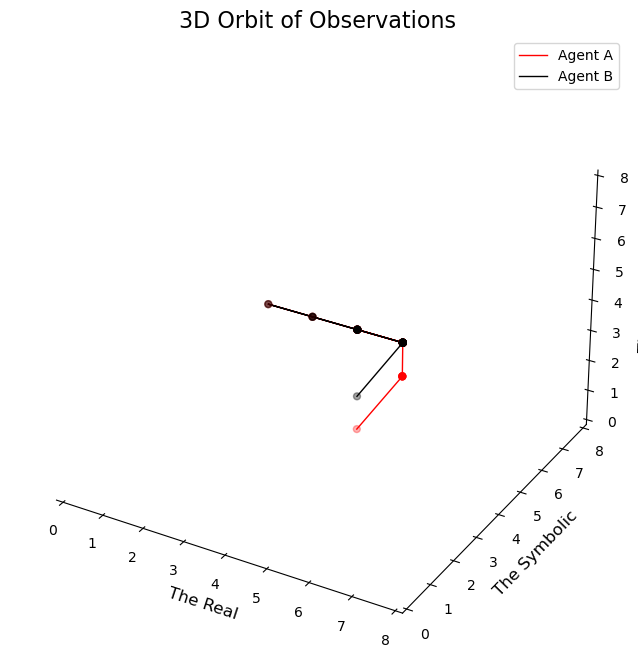

In [10]:
sync = Sync()
sync.run_active_inference(15)
sync.plot_trajectories()